In [1]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from growth.sweep.sweep import Sweep
from clones.visualization.settings import *
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from clones.annotation.spatial import WeightedGraph
from clones.annotation.spatial.sampling import NeighborSampler, CommunitySampler
from clones.annotation.annotation import MixtureModelAnnotation, DiffusionAnnotation

In [4]:
def score(x, y):
    """ Returns fraction of labels that are the same. """
    return (x==y).sum()/x.size

# Generate synthetic data

Load simulated bleedthrough control experiment and generate synthetic fluorescence data. Synthetic images contain three color channels:
   - BLUE: Nuclear stain
   - RED: Clonal marker
   - GREEN: Control reporter

In [5]:
ambiguity = 0.8

sweep = Sweep.load('../../../data/synthetic/sweeps/Sweep_181201_191516/')
simulation = sweep[0]

measurement_kwargs = dict(measurement_noise=0.)
microscopy_kwargs = dict(bg_level=0.2, bg_noise=0.3)

microscopy = simulation.generate_microscopy(ambiguity=ambiguity, rho=0.0, bleedthrough=0.5, 
                measurement_kwargs=measurement_kwargs, microscopy_kwargs=microscopy_kwargs)

data = microscopy.data

attr = 'clonal_marker'
graph = WeightedGraph(data, attr)

In [6]:
levels = graph.df.clonal_marker.values
diffused_levels = DiffusionAnnotation.diffuse_posteriors(graph, levels, alpha=0.9)

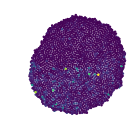

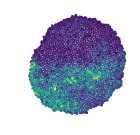

In [7]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.scatter(graph.df.centroid_x, graph.df.centroid_y, c=levels, s=2)
ax.axis('off')
ax.set_aspect(1)

fig, ax = plt.subplots(figsize=(2, 2))
ax.scatter(graph.df.centroid_x, graph.df.centroid_y, c=diffused_levels, s=2)
ax.axis('off')
ax.set_aspect(1)

In [8]:
from clones.annotation.classification import BivariateMixtureClassifier
values = np.vstack((levels, diffused_levels)).T
classifier = BivariateMixtureClassifier(values)

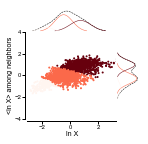

In [9]:
classifier.set_cmap(plt.cm.Reds)
_ = classifier.plot_bivariate_data(s=1, vmin=-5, vmax=2)

In [10]:
ground_truth = graph.df.true_dosage.values
predicted = classifier.classifier(np.log(values))

In [11]:
score(ground_truth, predicted)

0.4705056179775281

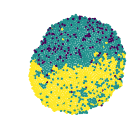

In [12]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.scatter(graph.df.centroid_x, graph.df.centroid_y, c=predicted, s=2)
ax.axis('off')
ax.set_aspect(1)

In [56]:
graph.find_communities(twolevel=True)

In [ ]:

community_levels = graph.df.groupby('community')['clonal_marker'].aggregate(lambda x: np.log(x).mean())
community_to_mean_level = np.vectorize(dict(community_levels).get)
local_average_levels = community_to_mean_level(graph.df.community.values)
levels = np.log(graph.df.clonal_marker.values)
community_sample = np.vstack((levels, local_average_levels)).T

In [111]:
sampler = CommunitySampler(graph, 'clonal_marker', twolevel=True)

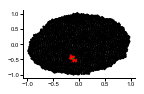

In [113]:
sampler.plot_neigborhood(30)

In [ ]:
mixture_labels = annotator.annotate(graph, resample=True, depth=depth)

diffusion_annotator = DiffusionAnnotation.copy(annotator)
diffusion_labels = diffusion_annotator.annotate(graph, resample=True, depth=depth)


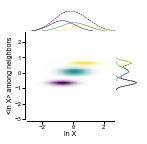

In [70]:
depth = 3
annotator = MixtureModelAnnotation('clonal_marker', min_num_components=3, max_num_components=3, depth=depth)
selector = annotator.train(graph)
#_ = selector.plot_information_criteria()
fig = annotator.classifier.plot_bivariate_pdf()

In [77]:
mixture_labels = annotator.annotate(graph, resample=True, depth=depth)
diffusion_annotator = DiffusionAnnotation.copy(annotator)
diffusion_labels = diffusion_annotator.annotate(graph, resample=True, depth=depth)
ground_truth = graph.df.true_dosage.values


multivariate_posteriors = annotator.classifier.posterior(annotator.classifier.values)

univariate_x_posteriors = annotator.classifier[0].posterior(annotator.classifier[0].values)
univariate_y_posteriors = annotator.classifier[1].posterior(annotator.classifier[1].values)


univariate_x_labels = univariate_x_posteriors.argmax(axis=1)

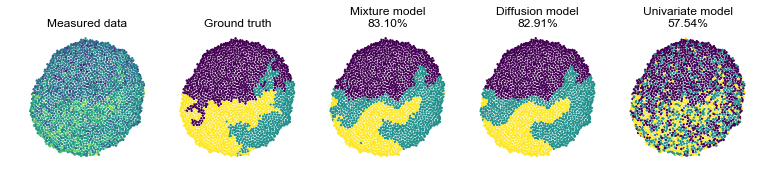

In [78]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(ncols=5, figsize=(13,3))

ax0.scatter(graph.df.centroid_x, graph.df.centroid_y, c=np.log(graph.df.clonal_marker), s=2)
ax0.set_title('Measured data')

ax1.scatter(graph.df.centroid_x, graph.df.centroid_y, c=graph.df.true_dosage, s=2)
ax1.set_title('Ground truth')

ax2.scatter(graph.df.centroid_x, graph.df.centroid_y, c=mixture_labels, s=2)
ax2.set_title('Mixture model\n{:0.2%}'.format(pct_error(ground_truth, mixture_labels)))

ax3.scatter(graph.df.centroid_x, graph.df.centroid_y, c=diffusion_labels, s=2)
ax3.set_title('Diffusion model\n{:0.2%}'.format(pct_error(ground_truth, diffusion_labels)))

ax4.scatter(graph.df.centroid_x, graph.df.centroid_y, c=univariate_x_labels, s=2)
ax4.set_title('Univariate model\n{:0.2%}'.format(pct_error(ground_truth, univariate_x_labels)))


for ax in (ax0, ax1, ax2, ax3, ax4):
    ax.axis('off')
    ax.set_aspect(1)

In [79]:
from copy import deepcopy
#hybrid_posteriors = deepcopy(multivariate_posteriors)
#mask = multivariate_posteriors.max(axis=1) <= univariate_posteriors.max(axis=1)


hybrid_posteriors = deepcopy(univariate_x_posteriors)


threshold = 0.8

mask = np.logical_and(multivariate_posteriors.max(axis=1) > threshold, univariate_x_posteriors.max(axis=1) < threshold)

hybrid_posteriors[mask, :] = multivariate_posteriors[mask, :]
hybrid_labels = hybrid_posteriors.argmax(axis=1)

diffused_hybrid_posteriors = diffusion_annotator.diffuse_posteriors(graph, hybrid_posteriors, alpha=.9)
diffused_hybrid_labels = diffused_hybrid_posteriors.argmax(axis=1)

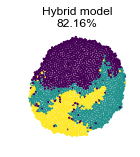

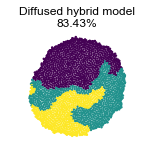

In [80]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.scatter(graph.df.centroid_x, graph.df.centroid_y, c=hybrid_labels, s=2)
ax.set_title('Hybrid model\n{:0.2%}'.format(pct_error(ground_truth, hybrid_labels)))
ax.axis('off')
ax.set_aspect(1)

fig, ax = plt.subplots(figsize=(2, 2))
ax.scatter(graph.df.centroid_x, graph.df.centroid_y, c=diffused_hybrid_labels, s=2)
ax.set_title('Diffused hybrid model\n{:0.2%}'.format(pct_error(ground_truth, diffused_hybrid_labels)))
ax.axis('off')
ax.set_aspect(1)

NameError: name 'univariate_x_posteriors' is not defined

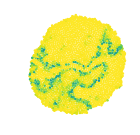

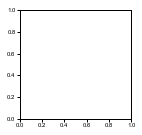

In [76]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.scatter(graph.df.centroid_x, graph.df.centroid_y, c=multivariate_posteriors.max(axis=1), s=2, vmin=0, vmax=1)
ax.axis('off')
ax.set_aspect(1)

fig, ax = plt.subplots(figsize=(2, 2))
ax.scatter(graph.df.centroid_x, graph.df.centroid_y, c=univariate_x_posteriors.max(axis=1), s=2, vmin=0, vmax=1)
ax.axis('off')
ax.set_aspect(1)

fig, ax = plt.subplots(figsize=(2, 2))
ax.scatter(graph.df.centroid_x, graph.df.centroid_y, c=univariate_y_posteriors.max(axis=1), s=2, vmin=0, vmax=1)
ax.axis('off')
ax.set_aspect(1)

array([[6.59209692e-086, 9.99565483e-001, 4.34516633e-004],
       [1.00009863e-075, 9.99918499e-001, 8.15011421e-005],
       [2.71137969e-072, 9.99955891e-001, 4.41086522e-005],
       ...,
       [1.83337327e-259, 1.48014534e-002, 9.85198547e-001],
       [1.35986000e-196, 1.03459795e-001, 8.96540205e-001],
       [1.51295081e-237, 2.47796802e-002, 9.75220320e-001]])

In [116]:
import networkx as nx

In [ ]:
"""
-could define neighborhood by cumulative traversed edge weight?

"""

In [153]:
mask.sum()/mask.size

0.8057116104868914

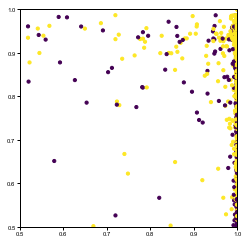

In [88]:
dim = 0
x = multivariate_posteriors.max(axis=1)
y = univariate_posteriors.max(axis=1)

fig, ax = plt.subplots()
ax.scatter(x, y, s=10, c=mixture_labels==univariate_labels, cmap=plt.cm.viridis)

ax.set_xlim(0.5, 1)
ax.set_ylim(0.5, 1)
ax.set_aspect(1)

In [202]:
posterior = get_posterior(annotator, graph, depth=3, resample=True)
adjacency = get_adjacency(graph, order_by_position=True)
diffused_posterior = diffuse_posteriors(posterior, adjacency, alpha=0.9)

initial_labels = posterior.argmax(axis=1)
final_labels = diffused_posterior.argmax(axis=1)
ground_truth = graph.df.true_dosage.values

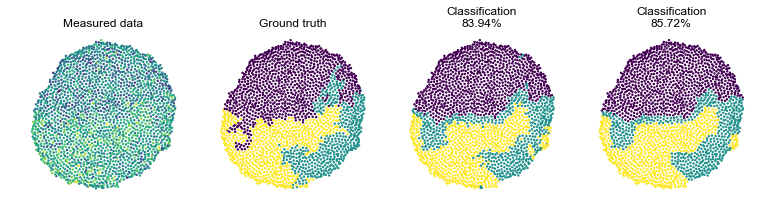

In [203]:

fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(13,3))

ax0.scatter(graph.df.centroid_x, graph.df.centroid_y, c=np.log(graph.df.clonal_marker), s=2)
ax0.set_title('Measured data')

ax1.scatter(graph.df.centroid_x, graph.df.centroid_y, c=graph.df.true_dosage, s=2)
ax1.set_title('Ground truth')

ax2.scatter(graph.df.centroid_x, graph.df.centroid_y, c=posterior.argmax(axis=1), s=2)
ax2.set_title('Classification\n{:0.2%}'.format(pct_error(ground_truth, initial_labels)))

ax3.scatter(graph.df.centroid_x, graph.df.centroid_y, c=diffused_posterior.argmax(axis=1), s=2)
ax3.set_title('Classification\n{:0.2%}'.format(pct_error(ground_truth, final_labels)))

for ax in (ax0, ax1, ax2, ax3):
    ax.axis('off')
    ax.set_aspect(1)

# Infomap

Applying classifier to local average within community.

In [38]:
graph.find_communities(twolevel=True)
community_levels = graph.df.groupby('community')['clonal_marker'].aggregate(lambda x: np.log(x).mean())
community_to_mean_level = np.vectorize(dict(community_levels).get)
local_average_levels = community_to_mean_level(graph.df.community.values)
levels = np.log(graph.df.clonal_marker.values)
community_sample = np.vstack((levels, local_average_levels)).T

In [40]:
community_posterior = annotator.classifier.posterior(community_sample)
adjacency = graph.adjacency_positional
community_diffused_posterior = diffuse_posteriors(community_posterior, adjacency, alpha=0.9)

NameError: name 'diffuse_posteriors' is not defined

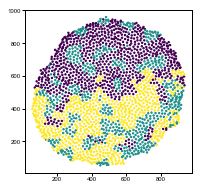

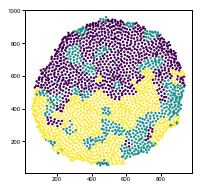

In [257]:
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(graph.df.centroid_x, graph.df.centroid_y, c=community_posterior.argmax(axis=1), s=2)

fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(graph.df.centroid_x, graph.df.centroid_y, c=community_diffused_posterior.argmax(axis=1), s=2)

In [ ]:

def get_posterior(self, graph, depth=None, resample=False):
    
    if depth is None:
        depth = self.depth

    # check if sample already exists
    if resample:
        sampler = SpatialSampler(graph, self.attribute, depth=depth)
        sample = sampler.sample
    else: 
        sample = graph.df[self.keys].values

    if self.classifier.log:
        sample = np.log(sample)

    # evaluate posterior label distribution for each node
    posterior = self.classifier.posterior(sample)
    
    return posterior

def get_adjacency(graph, order_by_position=True):
    adjacency = nx.to_numpy_array(graph.get_networkx(), nodelist=graph.nodes)
    
    if order_by_position:
        sort_ind = np.argsort(graph.position_map(graph.nodes))
        adjacency = adjacency[sort_ind, :][:, sort_ind]
    
    adjacency /= adjacency.sum(axis=0)
    return adjacency

def diffuse_posteriors(posterior, adjacency, alpha=0.9):

    n = np.array(adjacency).shape[0]
    external = np.eye(n, n) - (alpha * adjacency)
    internal = (1 - alpha) * posterior
    diffused_posteriors = np.linalg.solve(external, internal)

    return diffused_posteriors

def score(x, y):
    mae = np.abs(x-y).mean()
    pct = (x==y).sum()/x.size
    return mae, pct

def pct_error(x, y):
    pct = (x==y).sum()/x.size
    return pct

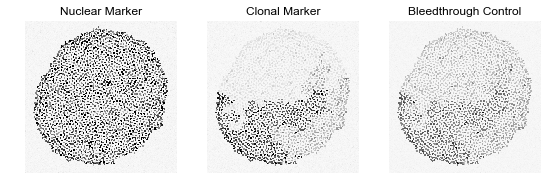

In [5]:
nuclear_marker = microscopy[0]
clonal_marker = microscopy[1]
control_reporter = microscopy[2]

fig = microscopy.render_panels(size=3)


import scipy.stats as st
def jensen_shannon_distance(x, y):
    """ Returns Jensen-Shannon distance between <x> and <y>. """
    return np.sqrt(0.5*(st.entropy(x, y, base=2)+st.entropy(y, x, base=2)))